<a href="https://colab.research.google.com/github/K4cp3rski/ML_FUW/blob/master/Cybinski_01_zadanie_domowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## "Should I stay, or should I go"
 
Wyobraź sobie, że dołączasz do grupy osób, które mają pomysł na "startup" - aplikację mobilną która wskazuje czy wybrany lot odleci o czasiem czy spóźni się o więcej niż 60'. Aplikacja będzie bardzo użyteczne - jeśli lot ma się opóźnić nie warto wyjeżdzać na lotnisko za wcześnie.

---
Zadanie: skonstruować model uczenia maszytnowego, który przyjume dane o locie, i zwraca informację: 

**Czy lot opóżni się o więcej niż 60'?**  - TAK/NIE
  
1) Proszę użyć nasdępujących modeli:
    * regresja logistyczna
    * naiwny klasyfikator Bayesa
    * drzewa decyzyjne
    * maszyna wektorów nośnych

2) Proszę wskazać kolumnę silnie skorelowaną z etykietą (odpowiedzią na pytanie zadane modelowi).

3) Proszę sprawdzić metryki modeli na zbiorze uczącym i testowym i wskazać model który jest najlepszy.

4) Proszę odpowiedzieć na pytanie: 

**Model stwierdził, że lot opóźni się o więcej niż 60' - użytkownik modelu wyszedł później na lotnisko. 
  Jakie jest prawdopodobieństwo, że w tej sytuacji lot jednak był o czasie (i użytkownik pewnie się na niego spóźnił)?**
  
5) Proszę wyjaśnić dlaczego modele działają tak dobrze.  

---  

**Opis danych:** "The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations."

**Lokalizacja danych:** Dane znajdują się na dysku Google tutaj: [flights.csv](https://drive.google.com/file/d/1ryE8mPQlommi88PaeiRSGQJOn4OYte64/view?usp=sharing). Najwygodniejszy sposób dostępu to czytadnie danych bezpośrednio z dysku Google. W tym celu należy utworzyć skrót do pliku na własnym dysku. Po kliknięciu w link należy utworzyć skrót do pliku na własnym dysku Google:

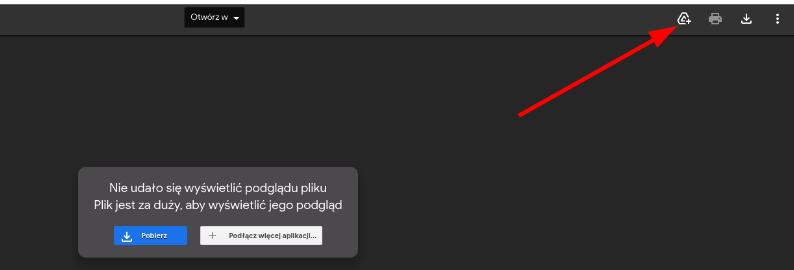



Następnie należy podłączyć dysk Google do środowiska Colab:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ścieżkę do pliku można znaleźć w menu plików z lewej strony:

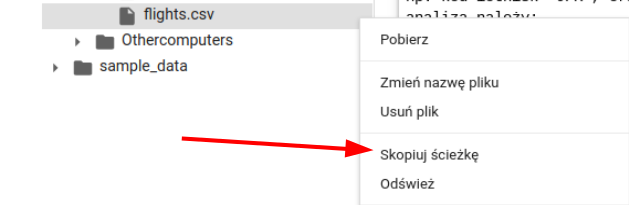


**Wstępna obróbka danych**: dane zawierają kolumny numeryczne, oraz z napisami, np. kod lotnisk "JFK", oraz wiersze gdzie niektóre kolumny są puste. Przed analizą należy:

* usunąć kolumny dla których zwykle nie ma żadnej informacji
* stworzyć kolumnę etykiet zawierającą wartości **0** lub **1** zależnie od tego czy opóźnenie było większe niż 60'
* zamienić napisy na wartości liczbowe korzystając z metody ```Pandas.factorize(...)```:
    
    ```
    df[column] =  pd.factorize(df[column])[0]
    ```
    
* niektóre wiersze mogą nadal zawierać nieokreślone wartości - ```NaN``` - należy je usunąć  
* danych jest bardzo dużo - by przyspieszyć obliczenia do treningu proszę użyć odpowiednio małej części
---
---

# <center>Rozwiązanie</center>


---
##Preprocessing danych

In [2]:
import pandas as pd
import numpy as np

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/ML_2021Z/flights.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
data = raw_data.copy()[0:int(raw_data.shape[0]*0.01)]
# BSO bierzemy do pracy 1% danych, dla oszczędności pamięci
data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58185,2015,1,4,7,DL,1822,N978AT,CHS,ATL,1730,1734.0,4.0,24.0,1758.0,79.0,82.0,51.0,259,1849.0,7.0,1849,1856.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
58186,2015,1,4,7,DL,696,N349NB,DTW,ORD,1730,1841.0,71.0,42.0,1923.0,82.0,122.0,53.0,235,1916.0,27.0,1752,1943.0,111.0,0,0,NaN,91.0,0.0,0.0,20.0,0.0
58187,2015,1,4,7,DL,754,N925AT,PIT,ATL,1730,1723.0,-7.0,9.0,1732.0,113.0,109.0,93.0,526,1905.0,7.0,1923,1912.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
58188,2015,1,4,7,DL,897,N944DN,MCO,ATL,1730,1724.0,-6.0,47.0,1811.0,100.0,123.0,65.0,404,1916.0,11.0,1910,1927.0,17.0,0,0,NaN,17.0,0.0,0.0,0.0,0.0


In [51]:
data = data.dropna(axis='columns', how='all', thresh=int(0.9*data.shape[0]))

In [52]:
headers = data.columns

In [53]:
headers

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED'],
      dtype='object')

In [54]:
data.insert(loc=0, column='DELAYED', value=data['DEPARTURE_DELAY'][data['DEPARTURE_DELAY'] > 60])
data['DELAYED'][data['DELAYED'] > 1] = 1
data['DELAYED'] = data['DELAYED'].fillna(0)
data['DELAYED']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is s

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
58185    0.0
58186    1.0
58187    0.0
58188    0.0
58189    0.0
Name: DELAYED, Length: 58190, dtype: float64

In [55]:
data

,DELAYED,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,0.0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0
1,0.0,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0
2,0.0,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0
3,0.0,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0
4,0.0,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58185,0.0,2015,1,4,7,DL,1822,N978AT,CHS,ATL,1730,1734.0,4.0,24.0,1758.0,79.0,82.0,51.0,259,1849.0,7.0,1849,1856.0,7.0,0,0
58186,1.0,2015,1,4,7,DL,696,N349NB,DTW,ORD,1730,1841.0,71.0,42.0,1923.0,82.0,122.0,53.0,235,1916.0,27.0,1752,1943.0,111.0,0,0
58187,0.0,2015,1,4,7,DL,754,N925AT,PIT,ATL,1730,1723.0,-7.0,9.0,1732.0,113.0,109.0,93.0,526,1905.0,7.0,1923,1912.0,-11.0,0,0
58188,0.0,2015,1,4,7,DL,897,N944DN,MCO,ATL,1730,1724.0,-6.0,47.0,1811.0,100.0,123.0,65.0,404,1916.0,11.0,1910,1927.0,17.0,0,0


In [56]:
names = ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
labels = {}
for i, name in enumerate(names):
  data[name], labels[name] = pd.factorize(data[name])
  # print(pd.factorize(data[name]))
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,DELAYED,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,0.0,2015,1,1,4,0,98,0,0,0,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0
1,0.0,2015,1,1,4,1,2336,1,1,1,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0
2,0.0,2015,1,1,4,2,840,2,2,2,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0
3,0.0,2015,1,1,4,1,258,3,1,3,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0
4,0.0,2015,1,1,4,0,135,4,3,4,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58185,0.0,2015,1,4,7,3,1822,3605,55,7,1730,1734.0,4.0,24.0,1758.0,79.0,82.0,51.0,259,1849.0,7.0,1849,1856.0,7.0,0,0
58186,1.0,2015,1,4,7,3,696,3996,122,12,1730,1841.0,71.0,42.0,1923.0,82.0,122.0,53.0,235,1916.0,27.0,1752,1943.0,111.0,0,0
58187,0.0,2015,1,4,7,3,754,3351,82,7,1730,1723.0,-7.0,9.0,1732.0,113.0,109.0,93.0,526,1905.0,7.0,1923,1912.0,-11.0,0,0
58188,0.0,2015,1,4,7,3,897,2266,20,7,1730,1724.0,-6.0,47.0,1811.0,100.0,123.0,65.0,404,1916.0,11.0,1910,1927.0,17.0,0,0


In [57]:
data = data.dropna(axis='rows', how='all', thresh=int(data.shape[1]))
data

,DELAYED,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
0,0.0,2015,1,1,4,0,98,0,0,0,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0
1,0.0,2015,1,1,4,1,2336,1,1,1,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0
2,0.0,2015,1,1,4,2,840,2,2,2,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0
3,0.0,2015,1,1,4,1,258,3,1,3,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0
4,0.0,2015,1,1,4,0,135,4,3,4,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58185,0.0,2015,1,4,7,3,1822,3605,55,7,1730,1734.0,4.0,24.0,1758.0,79.0,82.0,51.0,259,1849.0,7.0,1849,1856.0,7.0,0,0
58186,1.0,2015,1,4,7,3,696,3996,122,12,1730,1841.0,71.0,42.0,1923.0,82.0,122.0,53.0,235,1916.0,27.0,1752,1943.0,111.0,0,0
58187,0.0,2015,1,4,7,3,754,3351,82,7,1730,1723.0,-7.0,9.0,1732.0,113.0,109.0,93.0,526,1905.0,7.0,1923,1912.0,-11.0,0,0
58188,0.0,2015,1,4,7,3,897,2266,20,7,1730,1724.0,-6.0,47.0,1811.0,100.0,123.0,65.0,404,1916.0,11.0,1910,1927.0,17.0,0,0


Od razu podzielmy sobie dane na zbiór uczący i testowy, dzięki temu przy porównywaniu modeli będziemy mieć pewność, że każdy z nich jest trenowany i testowany na dokładnie takich samych zasadach.

In [58]:
# Importy do regresji logistycznej
import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # aby wykresy w Colabie były większe

import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics

Zainstalowana wersja scikit-learn: 1.0.1.


Tutaj podzielimy dane na dane wejściowe "X" i wyjściowe "y".

In [59]:
npdata = data.to_numpy()
X = npdata[:,1:]
y = npdata[:,0].reshape(-1,1)

Podzielmy je teraz na zbiory treningowe i testowe

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

W tym momencie mamy dane po pre-pocessingu i możemy je dać do przetrawienia modelom.



---

#Regresja logistyczna


In [61]:
from sklearn.linear_model import LogisticRegression

Tworzymy instancję modelu, którą dopasujemy do danych treningowych

In [62]:
model_log = LogisticRegression(solver = 'lbfgs', max_iter=10000)

In [63]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X = scaler.transform(X)

In [64]:
y_train = y_train.ravel()
model_log.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

###Sprawdźmy na zbiorze testowym

In [65]:
y_pred = model_log.predict(X_test)  

In [66]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('TN: ',tn,'FP: ', fp, 'FN: ', fn, 'TP: ', tp )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10275
         1.0       1.00      1.00      1.00      1070

    accuracy                           1.00     11345
   macro avg       1.00      1.00      1.00     11345
weighted avg       1.00      1.00      1.00     11345

[[10275     0]
 [    1  1069]]
TN:  10275 FP:  0 FN:  1 TP:  1069


In [67]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

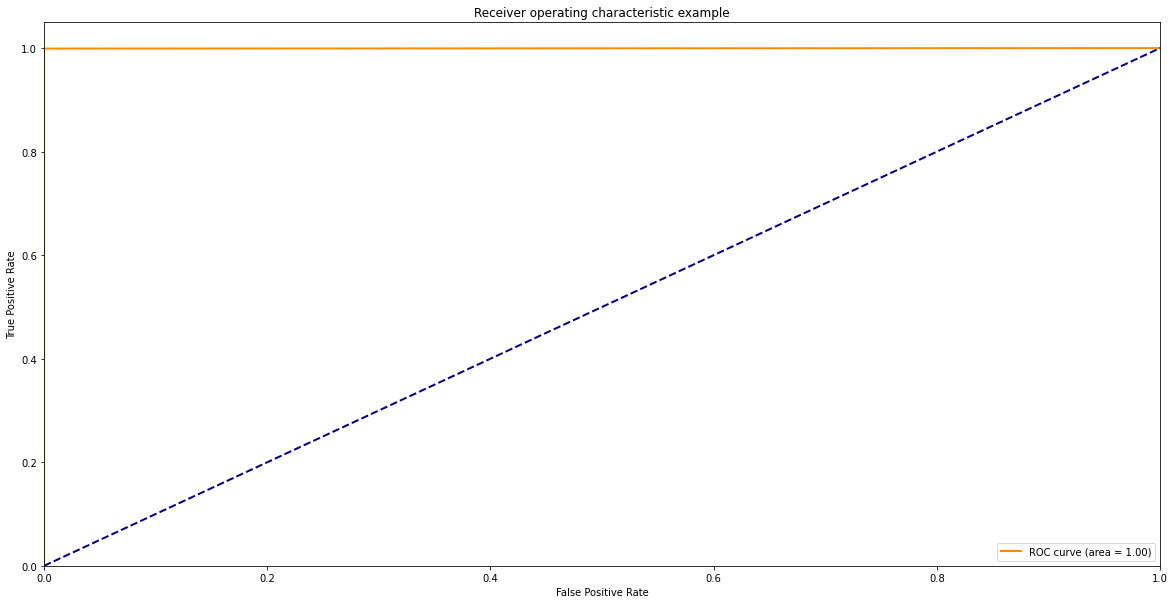

In [68]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Ciekawa obserwacja, na danych bez normalizacji nie ma żadnych błędów, ale czas trenowania modelu jest dłuższy, a na danych znormalizowanych minmaxscaler statystyki to:  
[ [10266     0]   
[  271     808] ]  
TN:  10266 FP:  0 FN:  271 TP:  808

###Sprawdźmy na całym zbiorze

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     51386
         1.0       1.00      1.00      1.00      5337

    accuracy                           1.00     56723
   macro avg       1.00      1.00      1.00     56723
weighted avg       1.00      1.00      1.00     56723

[[51386     0]
 [    1  5336]]
TN:  51386 FP:  0 FN:  1 TP:  5336


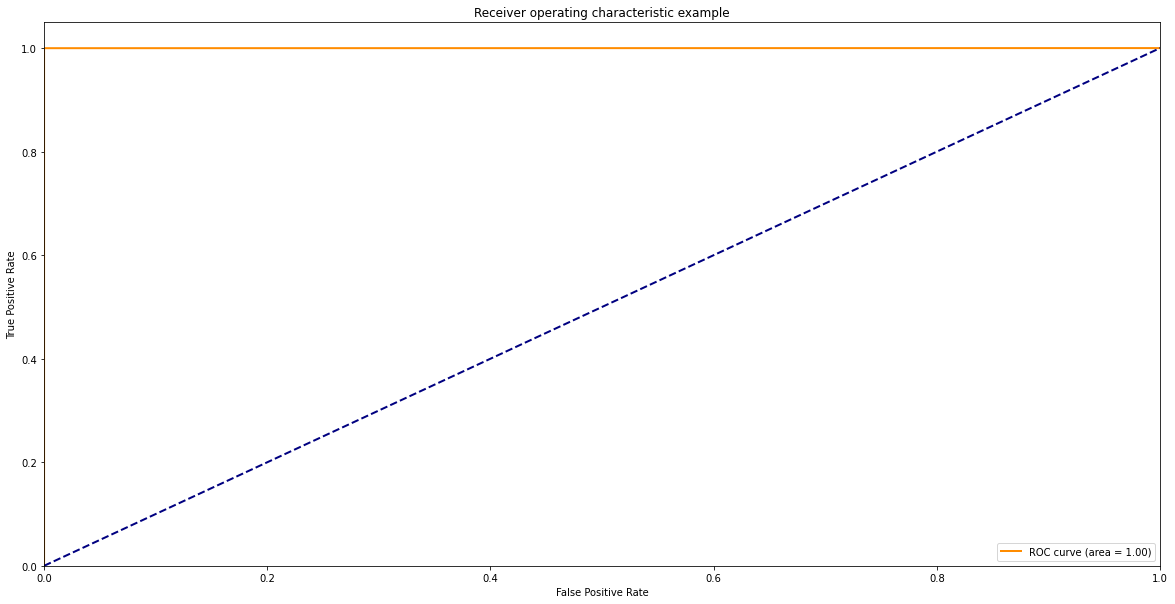

In [71]:
y_pred = model_log.predict(X)  

print(metrics.classification_report(y, y_pred))
print(metrics.confusion_matrix(y, y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
print('TN: ',tn,'FP: ', fp, 'FN: ', fn, 'TP: ', tp )

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


---
##Naive Bayes